## Project 3: Numerical Methods for Differential Equations

## Task 1

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, diags, identity
from scipy.linalg import toeplitz, norm
from scipy.sparse.linalg import spsolve, eigs
from mpl_toolkits.mplot3d import axes3d

## Part 1: The Diffusion Equation
The diffusion problem handled in this project is stated as follows:

\begin{equation*}
    \begin{cases}
        u_t=u_{xx}\\
        u(t,0)=u(t,1)=0\\
        u(0,x)=g(x)
    \end{cases}
\end{equation*}

To visualize the CFL condition that follows an explicit solving method of this system is done by using a central difference scheme for the spatial coordinate $x$ i.e.

\begin{equation*}
    u_{n}''=\frac{u_{n+1}-2u_n+u_{n-1}}{\Delta x^2}
\end{equation*}

Where $\Delta x$ is the steplength. For the temporal coordinate, the explicit euler method is used yielding:

\begin{equation*}
    v_{n+1}'(t)=(I+hA)y_n
\end{equation*}

Where $I$ is the identity matrix and $A$ is the matrix for expressing the right hand side, i.e. the $T_{\Delta x}$ operator matrix for central symmetric approximation of $\frac{\partial^2}{\partial x^2}$. The steps are implemented below.

In [29]:
def toeplitz_like(dim):
    return csr_matrix((diags([1, -2, 1], [-1, 0, 1], shape=(dim, dim))) * (dim + 1)**2)

def euler_step(A: np.array, y_n: np.array, h: float, alpha, beta):
    return np.concatenate(([alpha], y_n + h * A @ y_n.T, [beta]))

## Task 1.1

Given a function $g_0$, spatial and temporal steps $N,M$, a final temporal point $t_{end}$ and boundary conditions $y(t,0)=\alpha, \quad y(t,1)=\beta$; the functions below, yields a second order approximation of the solution to the system and enables visualisation of the solution by plotting a surface plot.

In [30]:
def euler_solve(g_0, N, M, t_end, alpha, beta):
    xx = np.linspace(0, 1, N+2)
    tt = np.linspace(0, t_end, M+1)
    Y = np.zeros((M+1, N+2))
    Y[0,:] = g_0(xx)
    toep = toeplitz_like(N)
    for i in range(M):
        Y[i+1,:] = euler_step(toep, Y[i,:][1:-1], t_end/M, alpha, beta)
    return Y, tt, xx

In [31]:
def plot3d(Y, Xgrid, tgrid):
     T, X = np.meshgrid(np.transpose(tgrid), Xgrid)

     fig = plt.figure(figsize=(10, 10))
     ax = fig.add_subplot(111, projection='3d')
     ax.plot_surface(T, X, np.transpose(Y))

     ax.set_xlabel('t')
     ax.set_ylabel('x')
     ax.set_title('Approximation of Solutions to the Diffusion Equation \n with initial value '+
                                    r'$u(0,x)=x(1-x)^2$')
     
     plt.show()

## Test Task 1.1
Below, the implemented code is tested for $g_0(x)=x(1-x)^2$, $N=25, M=2(N+1)^2$ (CFL condition), $\alpha=\beta=0$.

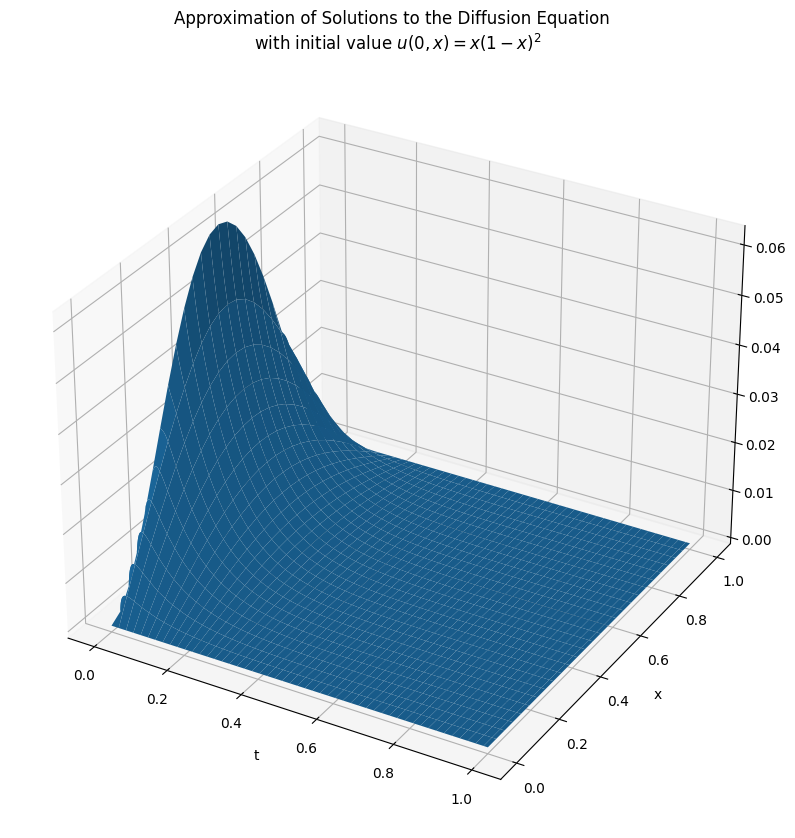

In [32]:
N = 25
M = 2*51**2
t_end = 1
alpha = 0
beta = 0

Y, t_grid, x_grid = euler_solve(lambda x : (x*(1-x))**2, N, M, t_end, alpha, beta)
plot3d(Y, x_grid, t_grid)

##  Experimental Determination of CFL condition

Below, a series of approximation are done for different values of the CFL constant $\mu=\frac{\Delta t}{\Delta x^2}$ to determine for which values the explicit Euler method converges. The theoretical value is $\mu\leq0.5$

In [33]:
def test_conv(mu, values, convergence):
    N = 25
    M = int(((N+1)**2)/mu)
    t_end = 1
    alpha = 0
    beta = 0
    Y, t_grid, x_grid = euler_solve(lambda x : (x*(1-x))**2, N, M, t_end, alpha, beta)
    
    if(np.sum(abs(Y[-1,:]))<0.001):
        values.append(f"CFL={mu}")
        convergence.append("Converges")
    else:
        values.append(f"CFL={mu}")
        convergence.append("Diverges")


In [34]:
values = []
convergence = []

for k in range(10):
    mu = (k+1) / 10 
    test_conv(mu, values, convergence)
    
df = pd.DataFrame({
    "values": values,
    "convergence": convergence,
    })

df.style \
.format(precision=3, thousands=".", decimal=",") \
.format_index(str.upper, axis=1)
display(df)

/var/folders/_f/c8hvdtx948gb848x9xmt79tr0000gn/T/ipykernel_206/4162189152.py:5: RuntimeWarning: invalid value encountered in add
  return np.concatenate(([alpha], y_n + h * A @ y_n.T, [beta]))


,values,convergence
0,CFL=0.1,Converges
1,CFL=0.2,Converges
2,CFL=0.3,Converges
3,CFL=0.4,Converges
4,CFL=0.5,Converges
5,CFL=0.6,Diverges
6,CFL=0.7,Diverges
7,CFL=0.8,Diverges
8,CFL=0.9,Diverges
9,CFL=1.0,Diverges


From the above broad testing, we can determine that the line of convergence is in the intervall $\mu\in[5,6)$.

In [35]:
values = []
convergence = []

testcases = [num/100 for num in range(50, 60)]
for test in testcases:
    test_conv(test, values, convergence)

df = pd.DataFrame({
    "values": values,
    "convergence": convergence,
    })

df.style \
.format(precision=3, thousands=".", decimal=",") \
.format_index(str.upper, axis=1)
display(df)

,values,convergence
0,CFL=0.5,Converges
1,CFL=0.51,Diverges
2,CFL=0.52,Diverges
3,CFL=0.53,Diverges
4,CFL=0.54,Diverges
5,CFL=0.55,Diverges
6,CFL=0.56,Diverges
7,CFL=0.57,Diverges
8,CFL=0.58,Diverges
9,CFL=0.59,Diverges


The inteval is now narrowed down to $\mu\in[0.5,0.51)$ and further experiments are conducted

In [36]:
def conv(mu):
    N = 25
    M = int(((N+1)**2)/mu)
    t_end = 1
    alpha = 0
    beta = 0
    Y, t_grid, x_grid = euler_solve(lambda x : (x*(1-x))**2, N, M, t_end, alpha, beta)
    if(np.sum(abs(Y[-1,:]))<0.00005):
        return True
    else:
        return False
    
mu = 0.505
while(not conv(mu)):
    mu -= (mu - 0.5)/2
print(mu)

0.50125


With a tolerance of $0.00005$, the first value of convergence is $\mu = 0.50125$ and for smaller values, the code takes too long to run without further optimization which leaves the experimenta result och the maximal CFL condition in the interval $\mu\in[0.5, 0.50125)$ which is very close to the theoretical value of $\frac{1}{2}$.

Visualisation of divergent solution:

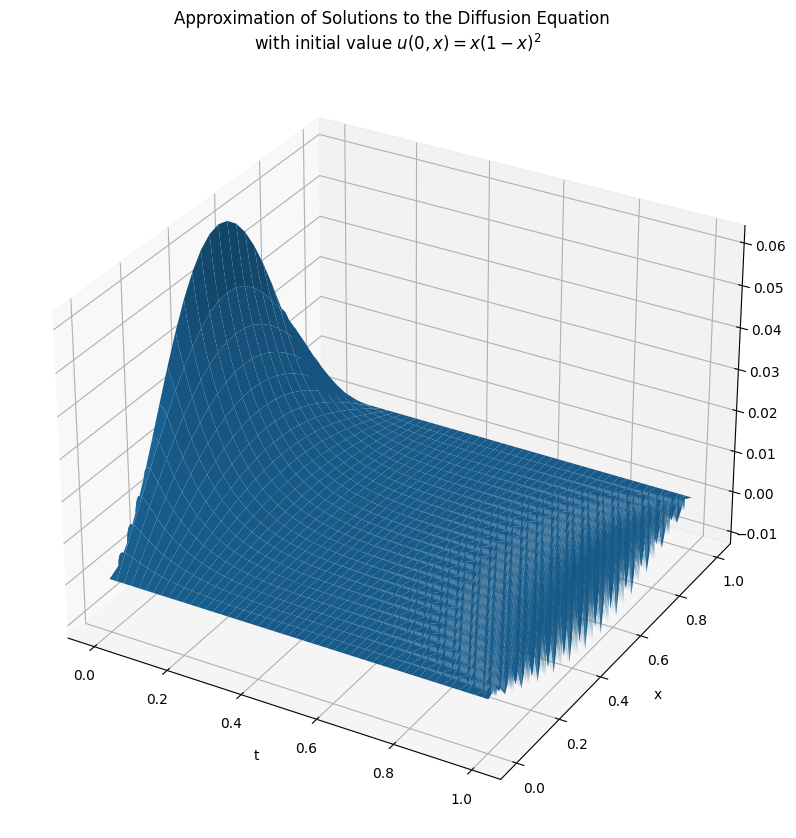

In [37]:
mu = 0.503
N = 25
M = int(((N+1)**2)/mu)
t_end = 1
alpha = 0
beta = 0
Y, t_grid, x_grid = euler_solve(lambda x : (x*(1-x))**2, N, M, t_end, alpha, beta)
plot3d(Y, x_grid, t_grid)

## Task 1.2

The CFL condition is a strong restriction for the time step $\Delta t$ as is is bounded by $\Delta x^2$, an implicit solver is preferable. The trapeziodal rule (Crank-Nicholson) is thus implemented below for approximating the same system.

\begin{equation*}
    u^{n+1}=u^n+\frac{1}{2}\Delta t\left(T_{\Delta x}u^n+T_{\Delta x}u^{n+1}\right) \implies
\end{equation*}

\begin{equation*}
    \implies u^{n+1}=\left(I-\frac{\Delta t}{2}T_{\Delta x}\right)^{-1}\left(I+\frac{\Delta t}{2}T_{\Delta x}\right)u^n
\end{equation*}

In [38]:
def Crank_Nicholson_step(Tdx, uold, dt, alpha, beta):
    I = identity(Tdx.get_shape()[0])
    RHS = I-0.5*dt*Tdx
    LHS = (I+0.5*dt*Tdx) @ (uold.T)
    return np.concatenate(([alpha], spsolve(RHS, LHS), [beta]))
        
def Crank_Nicholson_solver(g_0, N, M, t_end, alpha, beta):
    xx = np.linspace(0, 1, N+2)
    tt = np.linspace(0, t_end, M+1)
    Y = np.zeros((M+1, N+2))
    Y[0,:] = g_0(xx)
    toep = toeplitz_like(N)
    for i in range(M):
        Y[i+1,:] = Crank_Nicholson_step(toep, Y[i,:][1:-1], t_end/M, alpha, beta)
    return Y, tt, xx

Below, the system is approximated for $N,M=50$ to show that the method converges despite violation off the CFL condition.

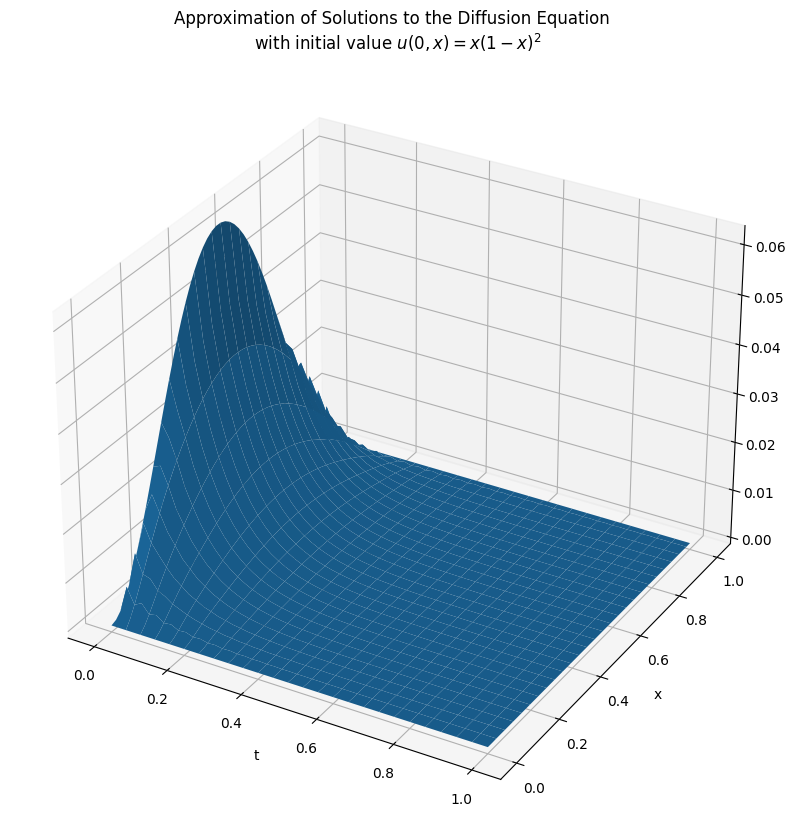

In [39]:
N = 50
M = 50
t_end = 1
alpha = 0
beta = 0
Y, t_grid, x_grid = Crank_Nicholson_solver(lambda x : (x*(1-x))**2, N, M, t_end, alpha, beta)
plot3d(Y, x_grid, t_grid)

## Part 2
Next, a second order solver for problems with the Advection equation is implemented.

\begin{equation*}
    \begin{cases}
        u_t = au_x\\
        u(t,0)=u(t,1), \forall t\\
        u(0,x)=g(x)
    \end{cases}
\end{equation*}
$\Delta x = \frac{1}{N}$, $N$ evaluation points, $x_1=0, x_{N+1}=1$ and $u_{N+1}=u_1$. $g(0)=g(1)$ and $g'(0)=g'(1)$

Implementation of code for approximating this system is done using the Lax-Wendroff scheme:
\begin{equation*}
    \begin{cases}
        u_j^{n+1}=\frac{a\mu}{2}(1+a\mu)_{j-1}^n+(1-a^2\mu^2)u_j^n+\frac{a\mu}{2}(a\mu-1)u_{j+1}^n\\
        \mu=\frac{\Delta t}{\Delta x}
    \end{cases}
\end{equation*}
The Toeplitz matrix is thus a circulant matrix described as:

$$
A=
\left(\begin{array}{c c c c} 
1-(a\mu)^2 & a\mu(a\mu-1) & \dots & a\mu(a\mu+1)\\
a\mu(a\mu+1) & 1-(a\mu)^2 & a\mu(a\mu-1) & \dots\\
\dots & \dots & \dots & \dots\\
a\mu(a\mu-1) & \dots & a\mu(a\mu+1) & 1-(a\mu)^2
\end{array}\right)
$$

In [40]:
def LaxWen_Toeplitz(amu, N):
     return csr_matrix(diags([amu/2*(amu-1), amu/2*(amu+1), 1-amu**2, amu/2*(amu-1), amu/2*(amu+1)],
                             [-(N-1), -1, 0, 1, N-1], shape=(N,N)))

def LaxWen_step(u_old, A):
     return A @ np.transpose(u_old)

def LaxWen_solver(g0, t_end, N, M, a):
     dt = t_end/M
     dx = 1/N
     amu = a*dt/dx

     x_grid = np.linspace(0, 1, N+1)
     t_grid = np.linspace(0, t_end, M+1)
     Y = np.zeros((M+1, N+1))
     Y[0,:] = g0(x_grid)

     A_amu = LaxWen_Toeplitz(amu, N+1)

     for t in range(M):
          Y[t+1, :] = LaxWen_step(Y[t,:], A_amu)

     return Y, x_grid, t_grid


def plot3d(Y, Xgrid, tgrid):
     T, X = np.meshgrid(np.transpose(tgrid), Xgrid)

     fig = plt.figure(figsize=(10, 10))
     ax = fig.add_subplot(111, projection='3d')
     ax.plot_surface(T, X, np.transpose(Y), rcount = 1000, ccount = 1000)

     ax.set_xlabel('t')
     ax.set_ylabel('x')
     ax.set_title('Approximation of Solutions to the Advection Equation \n with initial value '+
                                    r'$u(0,x)=e^{-100(x-0.5)^2}$')
     
     plt.show()

Below, the solution to a pulse $g_0(x)=e^{-100(x-1/2)^2}$, $N=M=1000$, $t_{end}=5$ and $a=-1$ is visualised as a surface plot and later as an animation of the approximation plotted against time.

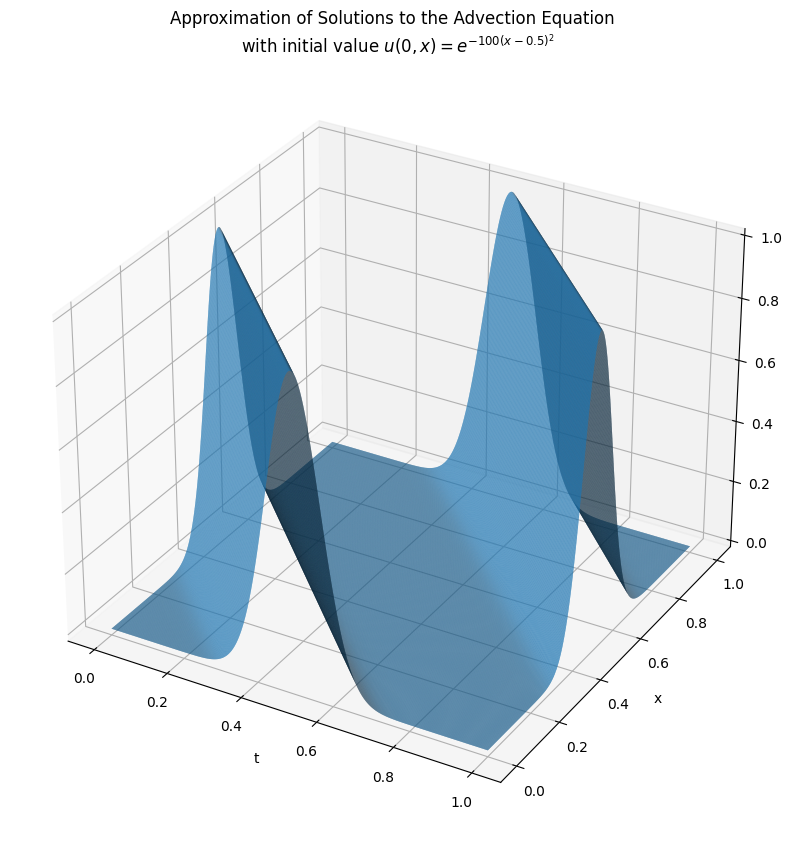

In [41]:
def pulse(x):
    return np.exp(-100*(x-0.5)**2)

a = -1
t_end = 1
N = 1000
M = 1000

Y, x_grid, t_grid = LaxWen_solver(pulse, t_end, N, M, a)
plot3d(Y, x_grid, t_grid)

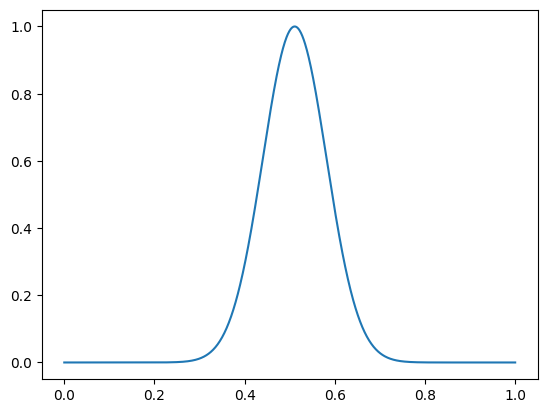

In [42]:
import time
import pylab as pl
from IPython.display import display, clear_output

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 

for i in range(100):
    ax.cla()
    ax.plot(x_grid, Y[10*i,:])
    display(fig)
    
    clear_output(wait = True)
    plt.pause(0.00000001)

To test the CFL condition on the solution, the system is solved with both $CFL = 0.9$ and $CFL = 1$. For $CFL = 1$, the value of $U_{j-1}^n\mapsto U_j^{n+1}$ and the Lax-Wendroff scheme should yield a constant amplitude to the solution as expected from the solution to the system. The amplitude is plotted as the root-mean-square value of the approximation vector for $CFL=0.9, 1$ to examine if the condition is reflected in the code above.

## CFL = 0.9
$CFL = |a\frac{\Delta t}{\Delta x}|= |a\frac{\frac{t_f}{M}}{\frac{1}{N}}|= |a\frac{t_fN}{M}|$

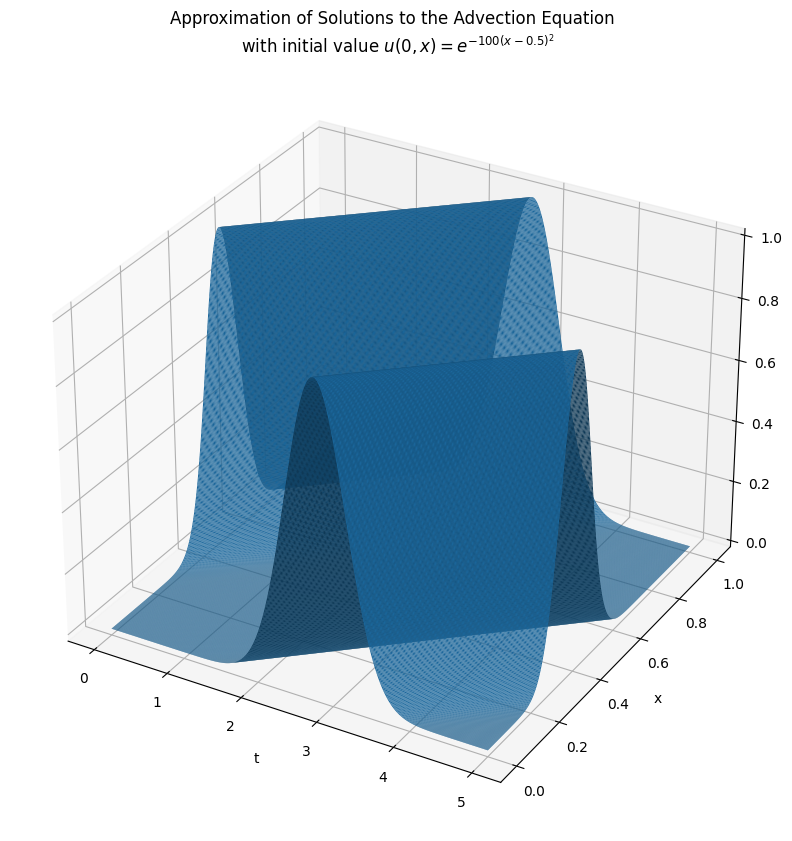

In [43]:
tf = 5
M = 1000
N = 1000
a = 0.9*M/tf/N
Y, x_grid, t_grid = LaxWen_solver(pulse, tf, N, M, a)
plot3d(Y, x_grid, t_grid)

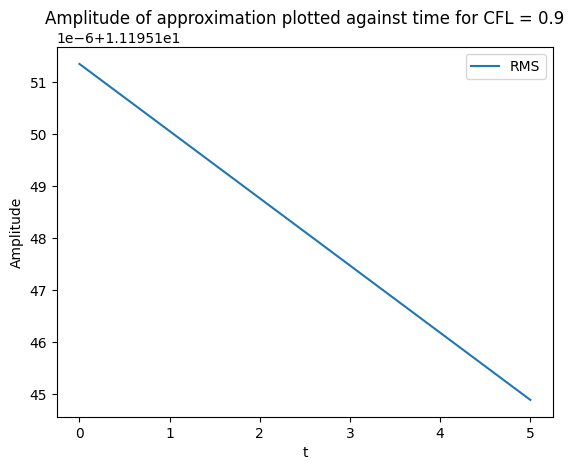

In [44]:
RMS = np.zeros(M+1)

for i in range(M+1):
    RMS[i] = norm(Y[i,:])

plt.plot(t_grid, RMS, label='RMS')
plt.title('Amplitude of approximation plotted against time for CFL = 0.9')
plt.xlabel('t')
plt.ylabel('Amplitude')
plt.legend()

## CFL = 1

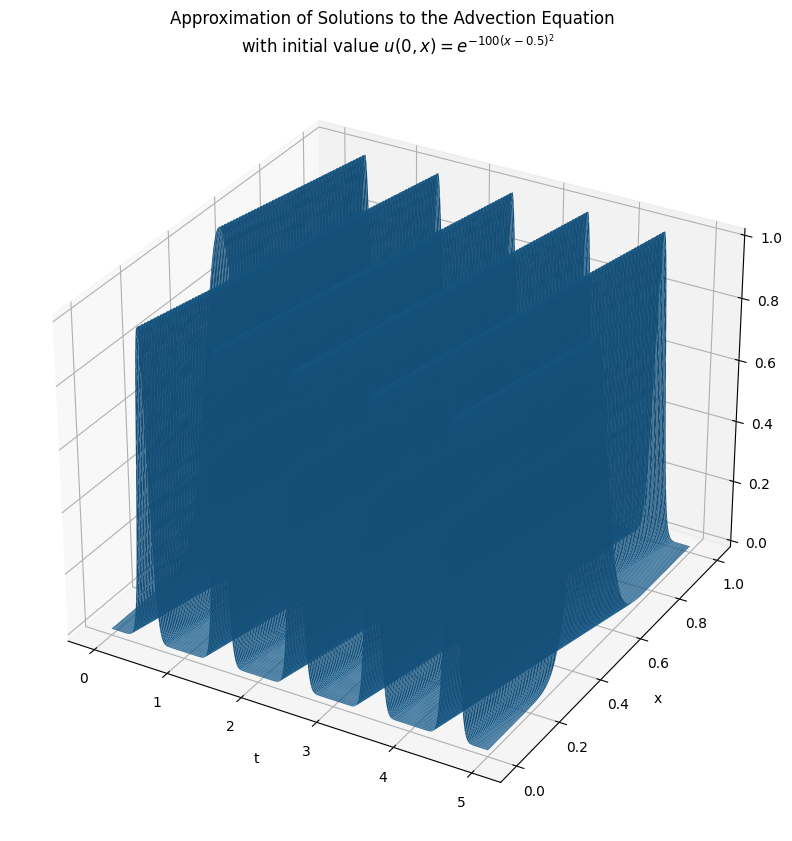

In [45]:
tf = 5
M = 1000
N = M/tf
a = M/tf/N
Y, x_grid, t_grid = LaxWen_solver(pulse, tf, int(N), M, a)
plot3d(Y, x_grid, t_grid)

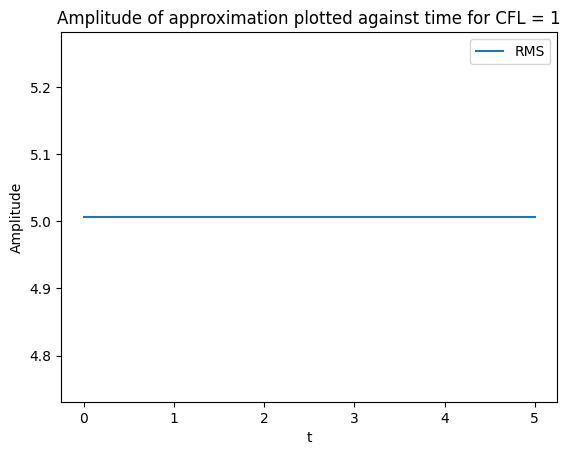

In [46]:
RMS = np.zeros(M+1)

for i in range(M+1):
    RMS[i] = norm(Y[i,:])

plt.plot(t_grid, RMS, label='RMS')
plt.title('Amplitude of approximation plotted against time for CFL = 1')
plt.xlabel('t')
plt.ylabel('Amplitude')
plt.legend()

## Part 3: The Convection-Diffusion Equation
The convection-diffusion equation is stated as:

\begin{equation*}
    u_t+au_x=du_{xx}
\end{equation*}

A solver using the central difference scheme in spatial coordinates and the trapeziodal rule for the temporal coordinate is implemented below.

Approximation scheme:
\begin{equation*}
    \frac{dU}{dt}=(dT_{\Delta x}-aS_{\Delta x})U
\end{equation*}

In [47]:
def con_fusion_matrix(d, a, dim):
    Tdx = (dim**2)*diags([1, 1, -2, 1, 1],[-(N-1), -1, 0, 1, N-1], shape=(N,N))
    Sdx = (dim)/2*diags([1,-1,0,1,-1],[-(N-1), -1, 0, 1, N-1], shape=(N,N))
    return csr_matrix(d*Tdx-a*Sdx)

def its_a_trap(A, dt, u_old):
    I = identity(A.get_shape()[0])
    LHS = I-0.5*dt*A
    RHS = (I+0.5*dt*A)@u_old.T
    u_new = spsolve(LHS, RHS)
    return np.append(u_new, u_new[0])

def con_fusion_solver(g0, a, d, N, M, t_end):
    dx = 1/N
    dt = t_end/M
    A = con_fusion_matrix(d, a, N+1)

    x_grid = np.linspace(0, 1, N+1)
    t_grid = np.linspace(0, t_end, M+1)
    Y = np.zeros((M+1, N+1))
    Y[0,:] = g0(x_grid)

    for t in range(M):
        Y[t+1,:] = its_a_trap(A, dt, Y[t,:][:-1])
    
    return Y, x_grid, t_grid
    
def plot3d(Y, Xgrid, tgrid):
    T, X = np.meshgrid(np.transpose(tgrid), Xgrid)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, np.transpose(Y), rcount= 1000, ccount = 1000)

    ax.set_xlabel('Time')
    ax.set_ylabel('Space')
    ax.set_zlabel('Value')
    ax.set_title('Approximation of Solutions to the Convection-Diffusion Equation \n with initial value '+
                                r'$u(0,x)=e^{-100(x-0.5)^2}$')

    plt.show()

## Test

Below the solver is tested on the pulse initial condition from above with $d=0.1, a = 1, N=M=1000$ in the interval $t\in[0,1]$

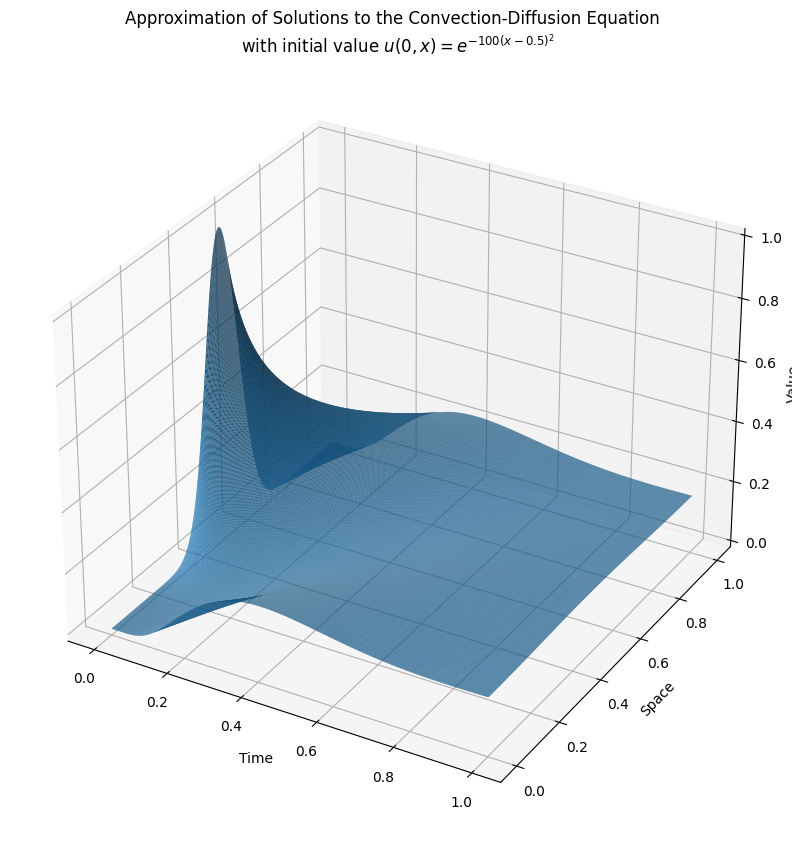

In [48]:
d = 0.1
a = 1
N = 1000
M = 1000
t_end = 1
Y, x, t = con_fusion_solver(pulse, a, d, N, M, t_end)
plot3d(Y, x, t)

The solver is used tested for the $Pe$ value in the interval $(0,1000]$. However, using the import scipy.sparse for solving, the solver worked for even higher values of $Pe$ and ten such solutions are presented below.

## Test for $Pe=|\frac{a}{d}|\in(0,1000]$

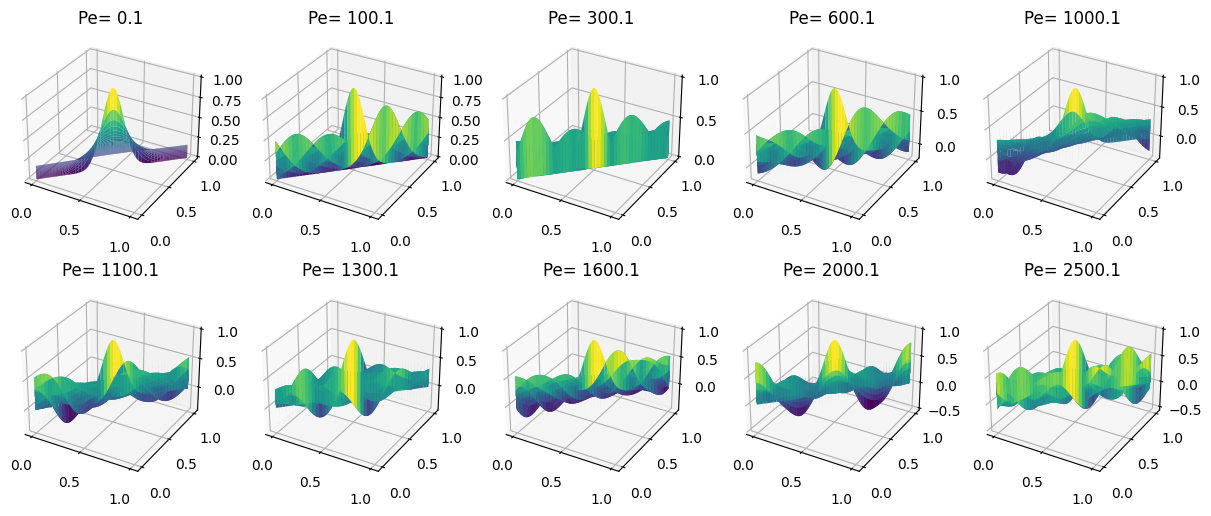

In [49]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6), subplot_kw={'projection': '3d'})

Pe = 0.1
for k in range(5):
    Pe += 100*k
    d = 0.1
    a = Pe*d
    Y, x, t = con_fusion_solver(pulse, a, d, int(N), M, t_end)
    axs[0, k].plot_surface(t, x, Y, cmap='viridis')
    axs[0, k].set_title('Pe= ' + str(Pe))

for k in range(5):
    Pe += 100*(k+1)
    d = 0.1
    a = Pe*d
    Y, x, t, = con_fusion_solver(pulse, a, d, int(N), M, t_end)
    axs[1, k].plot_surface(t, x, Y, cmap='viridis')
    axs[1, k].set_title('Pe= ' + str(Pe))

plt.show()

## Part 4: The viscous Burgers equation

The viscous Burgers' equation is as follows:
\begin{align*}
    u_t + uu_x = du_{xx} 
\end{align*}

Below, the following approximation for a time step $\Delta t$ will be used.
\begin{align*}
u(t+ \Delta t, x) \approx u(t,x) + \Delta tu_t+ \frac{1}{2}\Delta t^2u_{tt}
\end{align*}

For $d=0$, the inviscid Burgers' equation gives that $u_t=-uu_x$. Further:
\begin{align*}
    \begin{cases}
        u_{tt} = \frac{\partial}{\partial t}(-uu_x)=-u_tu_x-uu_{xt} \\
        u_{tx} = \frac{\partial}{\partial x}(-uu_x)=-u_x^2-uu_{xx}
    \end{cases} 
\end{align*}

Or, expressed in only spatial derivatives:
\begin{align*}
    \begin{cases}
        u_{t} = -uu_x \\
        u_{tt} = -u^2u_{xx}
    \end{cases} 
\end{align*}
The approximation scheme is thus:
\begin{align*}
u(t+ \Delta t, x) \approx u(t,x) - \Delta tuu_x- \frac{1}{2}\Delta t^2u^2u_{xx}
\end{align*}

With symmetric finite difference and notation $\mu = \frac{\Delta t}{\Delta x}$:
\begin{equation*}
    u_j^{n+1}=u_j^n-\frac{\mu}{2}u_j^n\left(u_{j+1}^n-u_{j-1}^n\right)+\frac{\mu^2}{2}(u_j^n)^2\left(u_{j+1}^n-2u_j^n+u_{j-1}^n\right)
\end{equation*}

For the temporal grid, inspiration is drawn from the trapeziodal rule to give the scheme where 

 $LW: u_j^{n+1}\mapsto u_j^n-\frac{\mu}{2}u_j^n\left(u_{j+1}^n-u_{j-1}^n\right)+\frac{\mu^2}{2}(u_j^n)^2\left(u_{j+1}^n-2u_j^n+u_{j-1}^n\right)$:

\begin{equation*}  
    \left(I-\frac{d\Delta t}{2}T_{dx}\right)u^{n+1}=LW(u^n) + \frac{d\Delta t}{2}T_{dx}u^n
\end{equation*}

Where $T_{dx}$ is the central difference matrix adapted to the circular boundary conditions. The entire scheme is implemented in the cell below.

In [62]:
def circ_centraldiff_matrices(N):
    Tdx = (N**2)*diags([1, 1, -2, 1, 1],[-(N-1), -1, 0, 1, N-1], shape=(N,N))
    # Sdx = (N)/2*diags([1,-1,0,1,-1],[-(N-1), -1, 0, 1, N-1], shape=(N,N))
    return Tdx #, csr_matrix(Sdx)

def Burgers_LW(u_n, mu, N):
    unew = np.zeros_like(u_n)
    for j in range(N):
        unew[j] = u_n[j]-0.5*mu*(u_n[(j+1)%N]-u_n[j-1])+0.5*mu**2*(u_n[j])**2*(u_n[(j+1)%N]-2*u_n[j]+u_n[j-1])
    return unew 
    
def Burgers_LWsolver(g0, N, M, t_end, d):
    dt = t_end / M
    dx = 1/N
    mu = dt/dx
    
    x_grid = np.linspace(0, 1, N+1)
    t_grid = np.linspace(0, t_end, M)
    Y = np.zeros((M, N+1))
    Y[0,:] = g0(x_grid)

    Tdx = circ_centraldiff_matrices(N+1)

    LHS = np.linalg.inv(np.identity(N+1) - 0.5*d*dt*Tdx)
    for t in range(M-1):
        RHS = Burgers_LW(Y[t,:], mu, N) + 0.5 * d * dt * Tdx @ (Y[t,:].T)
        Y[t+1,:] = LHS @ RHS
    
    return Y, x_grid, t_grid

def plot3d(Y, Xgrid, tgrid, title):
     T, X = np.meshgrid(np.transpose(tgrid), Xgrid)

     fig = plt.figure(figsize=(10, 10))
     ax = fig.add_subplot(111, projection='3d')
     ax.plot_surface(T, X, np.transpose(Y), rcount=300, ccount=1000)

     ax.set_xlabel('Time')
     ax.set_ylabel('Space')
     ax.set_zlabel('Value')
     ax.set_title(title)
     
     plt.show()

The solver is tested below for $d=0.01, N=300, M=100$ and $t\in[0,1]$. The result is plotted in the same fashion as previous tests. 

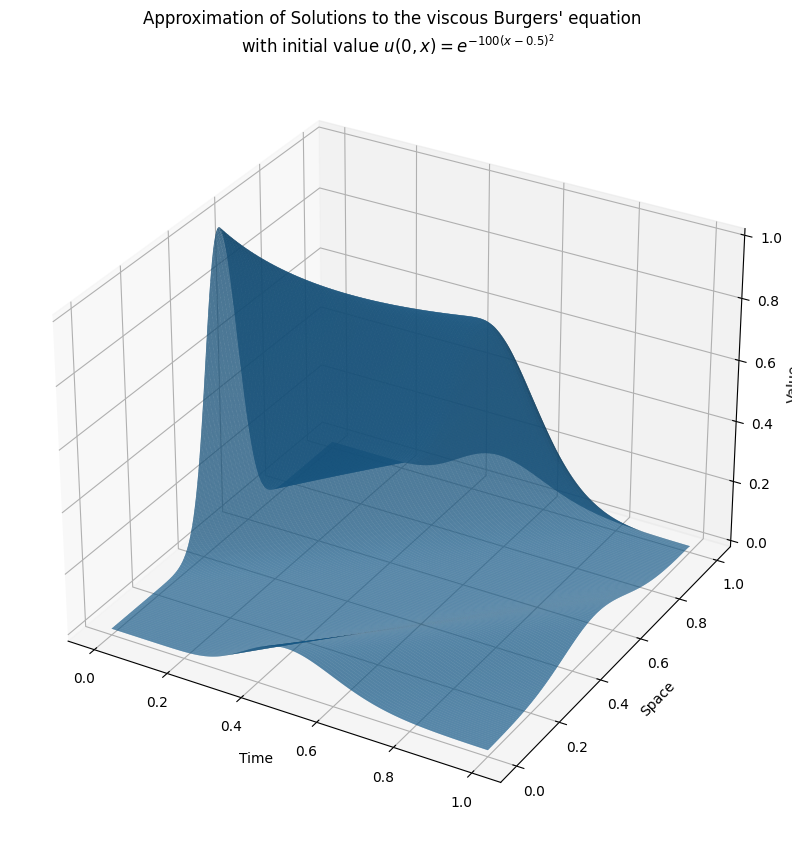

In [68]:
d, N, M, t_end = 0.01, 300, 1000, 1
Y, x, t = Burgers_LWsolver(pulse, N, M, t_end, d)
plot3d(Y, x, t, "Approximation of Solutions to the viscous Burgers\' equation \n with initial value " + r'$u(0,x)=e^{-100(x-0.5)^2}$')

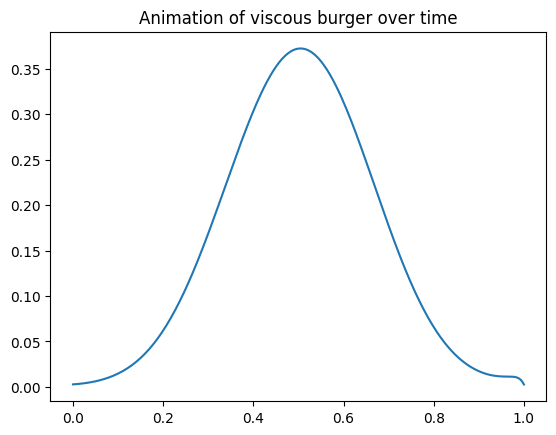

In [60]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for i in range(100):
    ax.cla()
    ax.plot(x, Y[10*i,:])
    ax.set_title("Animation of viscous burger over time") 

    display(fig)
    
    clear_output(wait = True)
    plt.pause(0.00000001)

An attempt to produce shock waves which is explained by Oxford dictionnary as -"a sharp change of pressure in a narrow region travelling through a medium" is done by increasing the amplitude of the pulse initial condition is done and visualised below. 

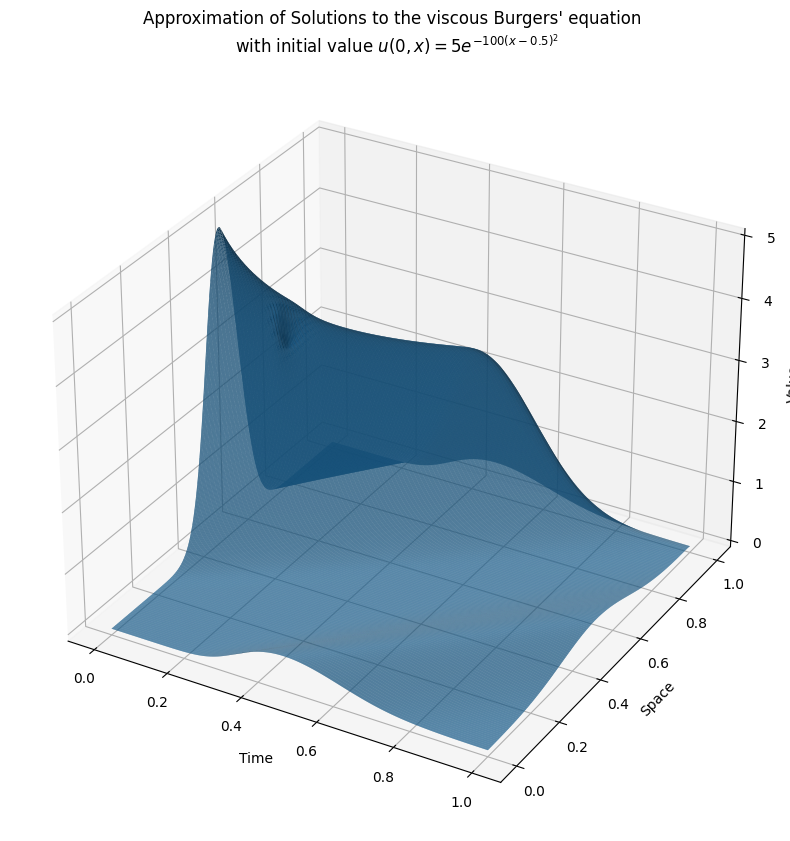

In [67]:
Y, x, t = Burgers_LWsolver(lambda x : 5*pulse(x), N, M , t_end, d)
plot3d(Y, x, t, "Approximation of Solutions to the viscous Burgers\' equation \n with initial value " + r'$u(0,x)=5e^{-100(x-0.5)^2}$')

Animation of amplitude of approximation plotted against time

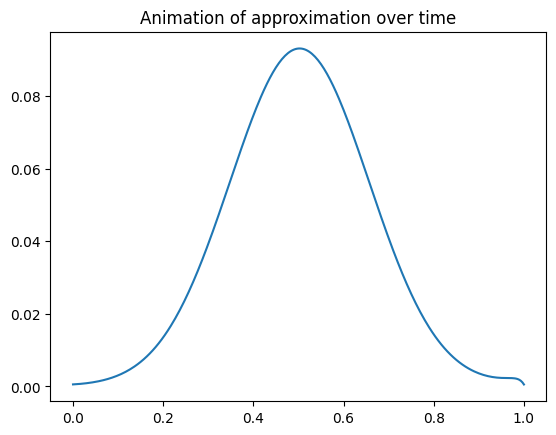

In [69]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 

for i in range(100):
    ax.cla()
    ax.plot(x, Y[10*i,:])
    ax.set_title("Animation of approximation over time") 
    display(fig)
    
    clear_output(wait = True)
    plt.pause(0.00000001)